# Разбор домашней работы

In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [2]:
# %cd /content/gdrive/My Drive/HSE_DL_2021/03_week

In [3]:
# %ls -a

In [4]:
from IPython import display

In [5]:
# !pip install torchmetrics

In [6]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

# Подгружаем pytorch 
import torch

print(torch.__version__)

import torch.nn as nn # содержит функции для реалзации архитектуры нейронных сетей
import torch.nn.functional as F # содержит различные функции активации и не только
import torch.optim as optim
import torch.utils.data as data_utils

from torchmetrics import Accuracy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

1.11.0


In [7]:
def load_dataset():
    X = pd.read_csv('../01_week/data/X_cat.csv', sep='\t', index_col=0)
    target = pd.read_csv('../01_week/data/y_cat.csv', sep='\t', index_col=0, names=['status'])  # header=-1,

    target = target.iloc[:, :].values
    target[target == 'Died'] = 'Euthanasia'

    le = LabelEncoder()
    y = le.fit_transform(target)

    return X, y

In [8]:
features, labels = load_dataset()

In [9]:
features.columns.values

array(['IsDog', 'Age', 'HasName', 'NameLength', 'NameFreq', 'MixColor',
       'ColorFreqAsIs', 'ColorFreqBase', 'TabbyColor', 'MixBreed',
       'Domestic', 'Shorthair', 'Longhair', 'Year', 'Month', 'Day',
       'Hour', 'Breed_Chihuahua Shorthair Mix',
       'Breed_Domestic Medium Hair Mix', 'Breed_Domestic Shorthair Mix',
       'Breed_German Shepherd Mix', 'Breed_Labrador Retriever Mix',
       'Breed_Pit Bull Mix', 'Breed_Rare', 'Sex_Female', 'Sex_Male',
       'Sex_Unknown', 'SexStatus_Flawed', 'SexStatus_Intact',
       'SexStatus_Unknown', 'Weekday_0', 'Weekday_1', 'Weekday_2',
       'Weekday_3', 'Weekday_4', 'Weekday_5', 'Weekday_6'], dtype=object)

In [10]:
features['Year']

0        2014
1        2013
2        2015
3        2014
4        2013
         ... 
26724    2015
26725    2016
26726    2015
26727    2014
26728    2015
Name: Year, Length: 26729, dtype: int64

1. Характеристика __Year__ принимает большие значения. 

При ненормализованных значениях поверхность оптимизируемой функции становится вытянутой, и найти локальный минимум становится сложнее.

In [11]:
display.Image('images/Unnormalized.png')

FileNotFoundError: No such file or directory: 'images/Unnormalized.png'

FileNotFoundError: No such file or directory: 'images/Unnormalized.png'

<IPython.core.display.Image object>

При обучении градиентный метод сходится медленно, и чтобы обучение шло, необходимо learning rate делать небольшим, то есть гораздо меньше, чем если данные были бы нормализованы.

In [12]:
display.Image('images/BadSurface.png')

FileNotFoundError: No such file or directory: 'images/BadSurface.png'

FileNotFoundError: No such file or directory: 'images/BadSurface.png'

<IPython.core.display.Image object>

При нормализованных характеристиках оптимизируемая поверхность становится симметричной, и метод сходится __быстрее__, т.е. сеть обучается быстрее.

In [13]:
display.Image('images/Normalized.png')

FileNotFoundError: No such file or directory: 'images/Normalized.png'

FileNotFoundError: No such file or directory: 'images/Normalized.png'

<IPython.core.display.Image object>

Другими словами, при прохождения через слои, нейроны будут уделять больше всего внимания именно этой характеристике, так как значение будет оставться большим, и зависимости между другими характеристиками искать не будут. 
Чтобы предотвратить все выше описанное, небходимо всегда делать __нормализацию__ входных данных.

2. Используемая функция активации `Sigmoid`, как уже упоминалось, она может приводить к обнулению градиентов, и сеть перестают хорошо обучаться. Поэтому можно попробовать другие нелинейные функции, например, `ReLU`. Но наиболее остро проблема с `Sigmoid` ощущается именно в глубоких нейронных сетях.

3. Так же можно изменить количество слоев и количество нейронов в скрытом слое. Нет четкого теоритического обоснования, сколько именно нейронов должно быть. Но есть некоторые эвристики, которые помогут уменьшить количетсво экспериментов для подбора нужного числа.

__Rules of Thumb__ (количество скрытых слоев)

1. В работах `Hornik, Stinchcombe and White 1989; Hornik 1993; Bishop 1995, 130, and Ripley, 1996, 173-180` указано, что можете взять __один слой__ и много нейронов и с этим аппроксимировать все, что угодно ("universal approximation"). Но нигде теоритически не подкреплено, сколько именно нейронов нужно, чтобы аппроксимировать любую функцию.

2. Но можно "подстраховаться" на случай, если целевая функция сложная и/или на оптимизируемой поверхности есть несколько возвышений, то тогда лучше сделать __два слоя__, и количество __нейронов не меньше двух__. (`Chester, D.L. (1990), "Why Two Hidden Layers are Better than One"`)

__Rules of Thumb__ (количество нейронов в скрытом слое)

1. Количество нейронов в скрытом слое: в промежутке сколько входных характеристик, и сколько выходных значений (Blum, A. (1992), Neural Networks in C++, NY: Wiley)
2. (Number of inputs + outputs) * (2/3)
3. Количество нейроной в скрытом слое не должно быть больше, чем в __два раза__ размера входного тензора. Swingler, K. (1996), Applying Neural Networks: A Practical Guide, London: Academic Press.
4. Зависит от количество наблюдений в обучающей выборке. Для данных размером от 150 до 2500 элементов __20__ нейронов достаточно для одного скрытого слоя.

In [14]:
INPUT_SIZE = 37
HIDDEN_SIZE = 26 #20 # 26
OUTPUT_SIZE = 4
LEARNING_RATE = 3e-4
EPOCHS = 100
BATCH_SIZE = 128

Для того чтобы подавать данные в нейронную сеть, создадим `DataLoader`, который предоставляет гибкий API для работы с входными данными.

__DataLoader__ для обучения сети

In [15]:
def create_data_loader(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X.iloc[:, :], y,
                                                        test_size=0.2, stratify=y, random_state=42)


    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    train_tensor = data_utils.TensorDataset(torch.tensor(X_train.astype(np.float32)), torch.tensor(y_train))
    train_loader = data_utils.DataLoader(dataset=train_tensor,
                                         batch_size=BATCH_SIZE,
                                         shuffle=True)

    test_tensor = data_utils.TensorDataset(torch.tensor(X_test.astype(np.float32)), torch.tensor(y_test))
    test_loader = data_utils.DataLoader(dataset=test_tensor,
                                        batch_size=BATCH_SIZE,
                                        shuffle=False)
    return train_loader, test_loader, X_test, y_test

In [16]:
train_loader, test_loader, X_test, y_test = create_data_loader(features, labels)

In [17]:
for X, y in train_loader:
    print(X.shape, y.shape)
    break

torch.Size([128, 37]) torch.Size([128])


__Архитектура модели__

Архитектуру нейронной сети в PyTorch можно описать нескольками способами, в дальнейшем мы рассмотрим их более подробно. Сейчас предлагается сделать это используя `Sequential`.
`Sequential` -- это последовательный способ объявления каждой компоненты архитектуры нейронной сети.

In [18]:
def build_model():
    model = nn.Sequential(  
        # Добавляем в нашу модель первый слой из 25 нейронов
        nn.Linear(in_features=INPUT_SIZE, out_features=HIDDEN_SIZE),
        nn.ReLU(),
        
        # Добавляем ещё один слой из 25 нейронов
        nn.Linear(in_features=HIDDEN_SIZE, out_features=HIDDEN_SIZE),
        nn.ReLU(),
        
        # Выходной вектор на количество классов, получаем с помощью такого же линейного приеобразования,
        # как и предыдущие слои, но уже на нужное количество выходных нейронов (т.е. классов)
        nn.Linear(in_features=HIDDEN_SIZE, out_features=OUTPUT_SIZE),
        nn.Softmax()
    )

    return model

Функция `Linear` представляет собой полносвязный слой, где присутствуют обучаемая матрица и обучаемый баес.

In [19]:
display.Image('images/FClayer.png')

FileNotFoundError: No such file or directory: 'images/FClayer.png'

FileNotFoundError: No such file or directory: 'images/FClayer.png'

<IPython.core.display.Image object>

In [20]:
model = build_model()

In [21]:
print(model)

Sequential(
  (0): Linear(in_features=37, out_features=26, bias=True)
  (1): ReLU()
  (2): Linear(in_features=26, out_features=26, bias=True)
  (3): ReLU()
  (4): Linear(in_features=26, out_features=4, bias=True)
  (5): Softmax(dim=None)
)


На лекции была представлена возможная архитектура сети для задачи классификации. Сейчас мы тоже собрали свою сеть с одним скрытым слоем.

In [22]:
display.Image('images/MLP2.jpg')

FileNotFoundError: No such file or directory: 'images/MLP2.jpg'

FileNotFoundError: No such file or directory: 'images/MLP2.jpg'

<IPython.core.display.Image object>

Обратите внимание, что последняя функция в в архитектуре сети -- это `Softmax`. Напомним, что `Softamx` используется для задачи классификации, чтобы получить значение увернности сети по каждому классу. Получается вектор на заданное количество классов, где наибольшее значение в какой-либо координате говорит о том, что сеть считает данный класс наиболее подходящим для данного наблюдения.

In [23]:
display.Image('images/Softmax.png')

FileNotFoundError: No such file or directory: 'images/Softmax.png'

FileNotFoundError: No such file or directory: 'images/Softmax.png'

<IPython.core.display.Image object>

Отлично! Только что мы собрали свою первую нейросеть со скрытым слоем. Осталось ее обучить.

__Обучение модели__

Перед тем как обучать нашу нейросеть, нужно задать параметры обучения. 
- Во-первых, метод оптимизации. 
- Во-вторых, функцию потерь. 
- В-третьих, парочку метрик, на которые нам хотелось бы смотреть в процессе обучения.  

**Использование GPU для вычислений**

Для взаимодейтсвия с GPU в PyTorch реализован пакет `torch.cuda`. В этом пакете добавлена поддержка CUDA тензоров, которые ничем не отличаются от CPU тензоров, но используют графические процессоры для вычислений (GPU).

`torch.cuda` использует, так называемые, ленивые вычисления - стратегию, согласно которой вычисления следует откладывать до тех пор, пока не понадобится их результат. В связи с этим перед началом работы с GPU можно вызвать метод `is_available()`, чтобы определить, поддерживает ли ваша система CUDA.

Ниже приведены основные полезные методы `torch.cuda`. Полный список приведен в официальной [документации](https://pytorch.org/docs/stable/cuda.html)

In [24]:
print('Is CUDA available: ', torch.cuda.is_available())
print(torch.device('cuda:0'))

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('\nDevice name:', torch.cuda.get_device_name(device))
print('Device count:', torch.cuda.device_count())

print('\nCurrent device:', torch.cuda.current_device())
torch.cuda.set_device(device)
print('Current device:', torch.cuda.current_device())

Is CUDA available:  False
cuda:0


AssertionError: Torch not compiled with CUDA enabled

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

criterion = nn.CrossEntropyLoss()
accuracy = Accuracy()
# accuracy = (predict==labels).mean()

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

cpu


Создадим массивы, куда будем складывать значение целевой функции на обучающей и валиационной выборках, а также точность.

Ниже представлен код __обучения__ сети. Нужно обратить внимание на несколько моментов:
1. Обучение ведется в течение нескольких эпох -- что значит несколько проходов по выборке.
2. `train_loader` позволяет итеративно проходится по выборке и на каждой итерации получать батч заранее заданного размера.
3. На каждом шаге обнуляем градиенты `optimizer.zero_grad()`, чтобы не накапливать их, тем самым неккоректно обновлять веса.
4. Вызывать явно `loss.backward()` для вычисления градиентов.
5. Вызывать явно `optimizer.step()` для обновления весов.

In [26]:
step = 0
train_loss_values = []
train_accuracy_values = []
valid_loss_values = []
valid_accuracy = []

def run_train(model):
    step = 0
    for epoch in range(EPOCHS):
        running_loss = []
        running_acc = []
        for features, label in train_loader:
            features = features.to(device)
            # Reset gradients
            optimizer.zero_grad()

            output = model(features)
            # Calculate error and backpropagate
            loss = criterion(output.cpu(), label)
            loss.backward()
            acc = accuracy(output.cpu(), label).item()

            # Update weights with gradients
            optimizer.step()

            running_loss.append(loss.item())
            running_acc.append(acc)

        train_loss_values.append(np.mean(running_loss))
        train_accuracy_values.append(np.mean(running_acc))
        if epoch % 20 == 0:
            print('EPOCH %d : train_loss: %f train_acc: %f' % (epoch, train_loss_values[-1], train_accuracy_values[-1]))


        # Run validation
        running_loss = []
        running_acc = []
        for features, label in test_loader:
            features = features.to(device)
            output = model(features)
            # Calculate error and backpropagate
            loss = criterion(output.cpu(), label)
            acc = accuracy(output.cpu(), label).item()

            running_loss.append(loss.item())
            running_acc.append(acc)

        valid_loss_values.append(np.mean(running_loss))
        valid_accuracy.append(np.mean(running_acc))
        if epoch % 20 == 0:
            print('EPOCH %d : valid_loss: %f valid_acc: %f' % (epoch, valid_loss_values[-1], valid_accuracy[-1]))
        
    return train_loss_values, train_accuracy_values, valid_loss_values, valid_accuracy

In [27]:
model.to(device)
train_loss_values, train_accuracy_values, valid_loss_values, valid_accuracy = run_train(model)

EPOCH 0 : train_loss: 1.332019 train_acc: 0.373133
EPOCH 0 : valid_loss: 1.271941 valid_acc: 0.458937
EPOCH 20 : train_loss: 1.083402 train_acc: 0.652829
EPOCH 20 : valid_loss: 1.093013 valid_acc: 0.643912
EPOCH 40 : train_loss: 1.073497 train_acc: 0.665816
EPOCH 40 : valid_loss: 1.090271 valid_acc: 0.645287
EPOCH 60 : train_loss: 1.069241 train_acc: 0.673310
EPOCH 60 : valid_loss: 1.088807 valid_acc: 0.649121
EPOCH 80 : train_loss: 1.064480 train_acc: 0.679787
EPOCH 80 : valid_loss: 1.089496 valid_acc: 0.648191


 Посмотрим на динамику ошибки и значение точности нашей модели во времени.

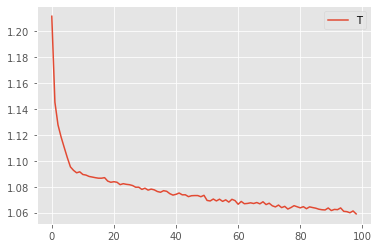

In [28]:
start = 1
plt.plot(train_loss_values[start:])
plt.legend('Train loss')

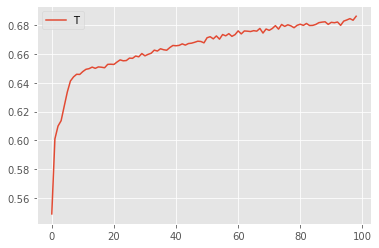

In [29]:
start = 1
plt.plot(train_accuracy_values[start:])
plt.legend('Train accuracy')

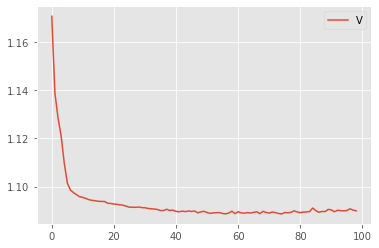

In [30]:
plt.plot(valid_loss_values[start:])
plt.legend('Validation loss')

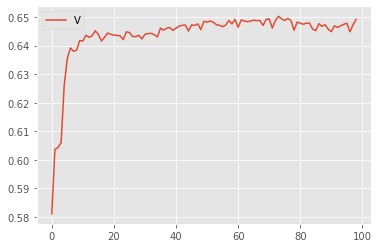

In [31]:
plt.plot(valid_accuracy[start:])
plt.legend('Validation accuracy')

Сохраним модель. Файл может иметь два расширения, как .pt, так и .pth. 

In [32]:
torch.save(model, 'simple_nn.pth')

Теперь загрузим сохраненную модель и посмотрим на ее предсказания. Важно! Когда идет этап inference модели, то нужно явно вызвать `model.eval()`, так как в случае если есть droupout или batch norm, то они не дложны работать как в процессе обучения, иначе они продолжат обучаться. 

In [33]:
model = torch.load('simple_nn.pth')
model.eval()

Sequential(
  (0): Linear(in_features=37, out_features=26, bias=True)
  (1): ReLU()
  (2): Linear(in_features=26, out_features=26, bias=True)
  (3): ReLU()
  (4): Linear(in_features=26, out_features=4, bias=True)
  (5): Softmax(dim=None)
)

### Расчет точности без использования `torchmetrics.Accuracy`

In [34]:
with torch.no_grad():
    test_scores = model(torch.tensor(X_test, dtype=torch.float).to(device))

print((test_scores.cpu().numpy().argmax(axis=1) == y_test).mean())

0.6492704826038159
